# RESNET MODEL (FROM SCRATCH)

**Import statements**

In [1]:
import os
import random
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Conv2D, ELU, BatchNormalization,concatenate, \
                                    Add, GlobalAveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Set up random seed**

In [2]:
radom_seed = 0
random.seed(radom_seed)
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
set_seed(tensorflow_seed)

**Set up config variables**

In [3]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 32,32,3,10
INPUT_DIR = "./cifar10/"
SAVE_DIRECTORY = "./cifar10/numpy_data/"
MODEL_DIR = "./models/"

**Create a dir for keras model file if does not exist**

In [4]:
if "models" not in os.listdir("./"):
    os.makedirs(MODEL_DIR)

## 1. Visualize Image Data

In [5]:
classes_to_labels = dict(zip(list(os.walk(INPUT_DIR+"train/"))[0][1], [i for i in range(10)]))
labels_to_classes = dict(zip([i for i in range(10)], list(os.walk(INPUT_DIR+"train/"))[0][1]))

In [6]:
X_train = np.load(SAVE_DIRECTORY+"X_train.npy")
X_valid = np.load(SAVE_DIRECTORY+"X_valid.npy")
Y_train = np.load(SAVE_DIRECTORY+"Y_train.npy")
Y_valid = np.load(SAVE_DIRECTORY+"Y_valid.npy")

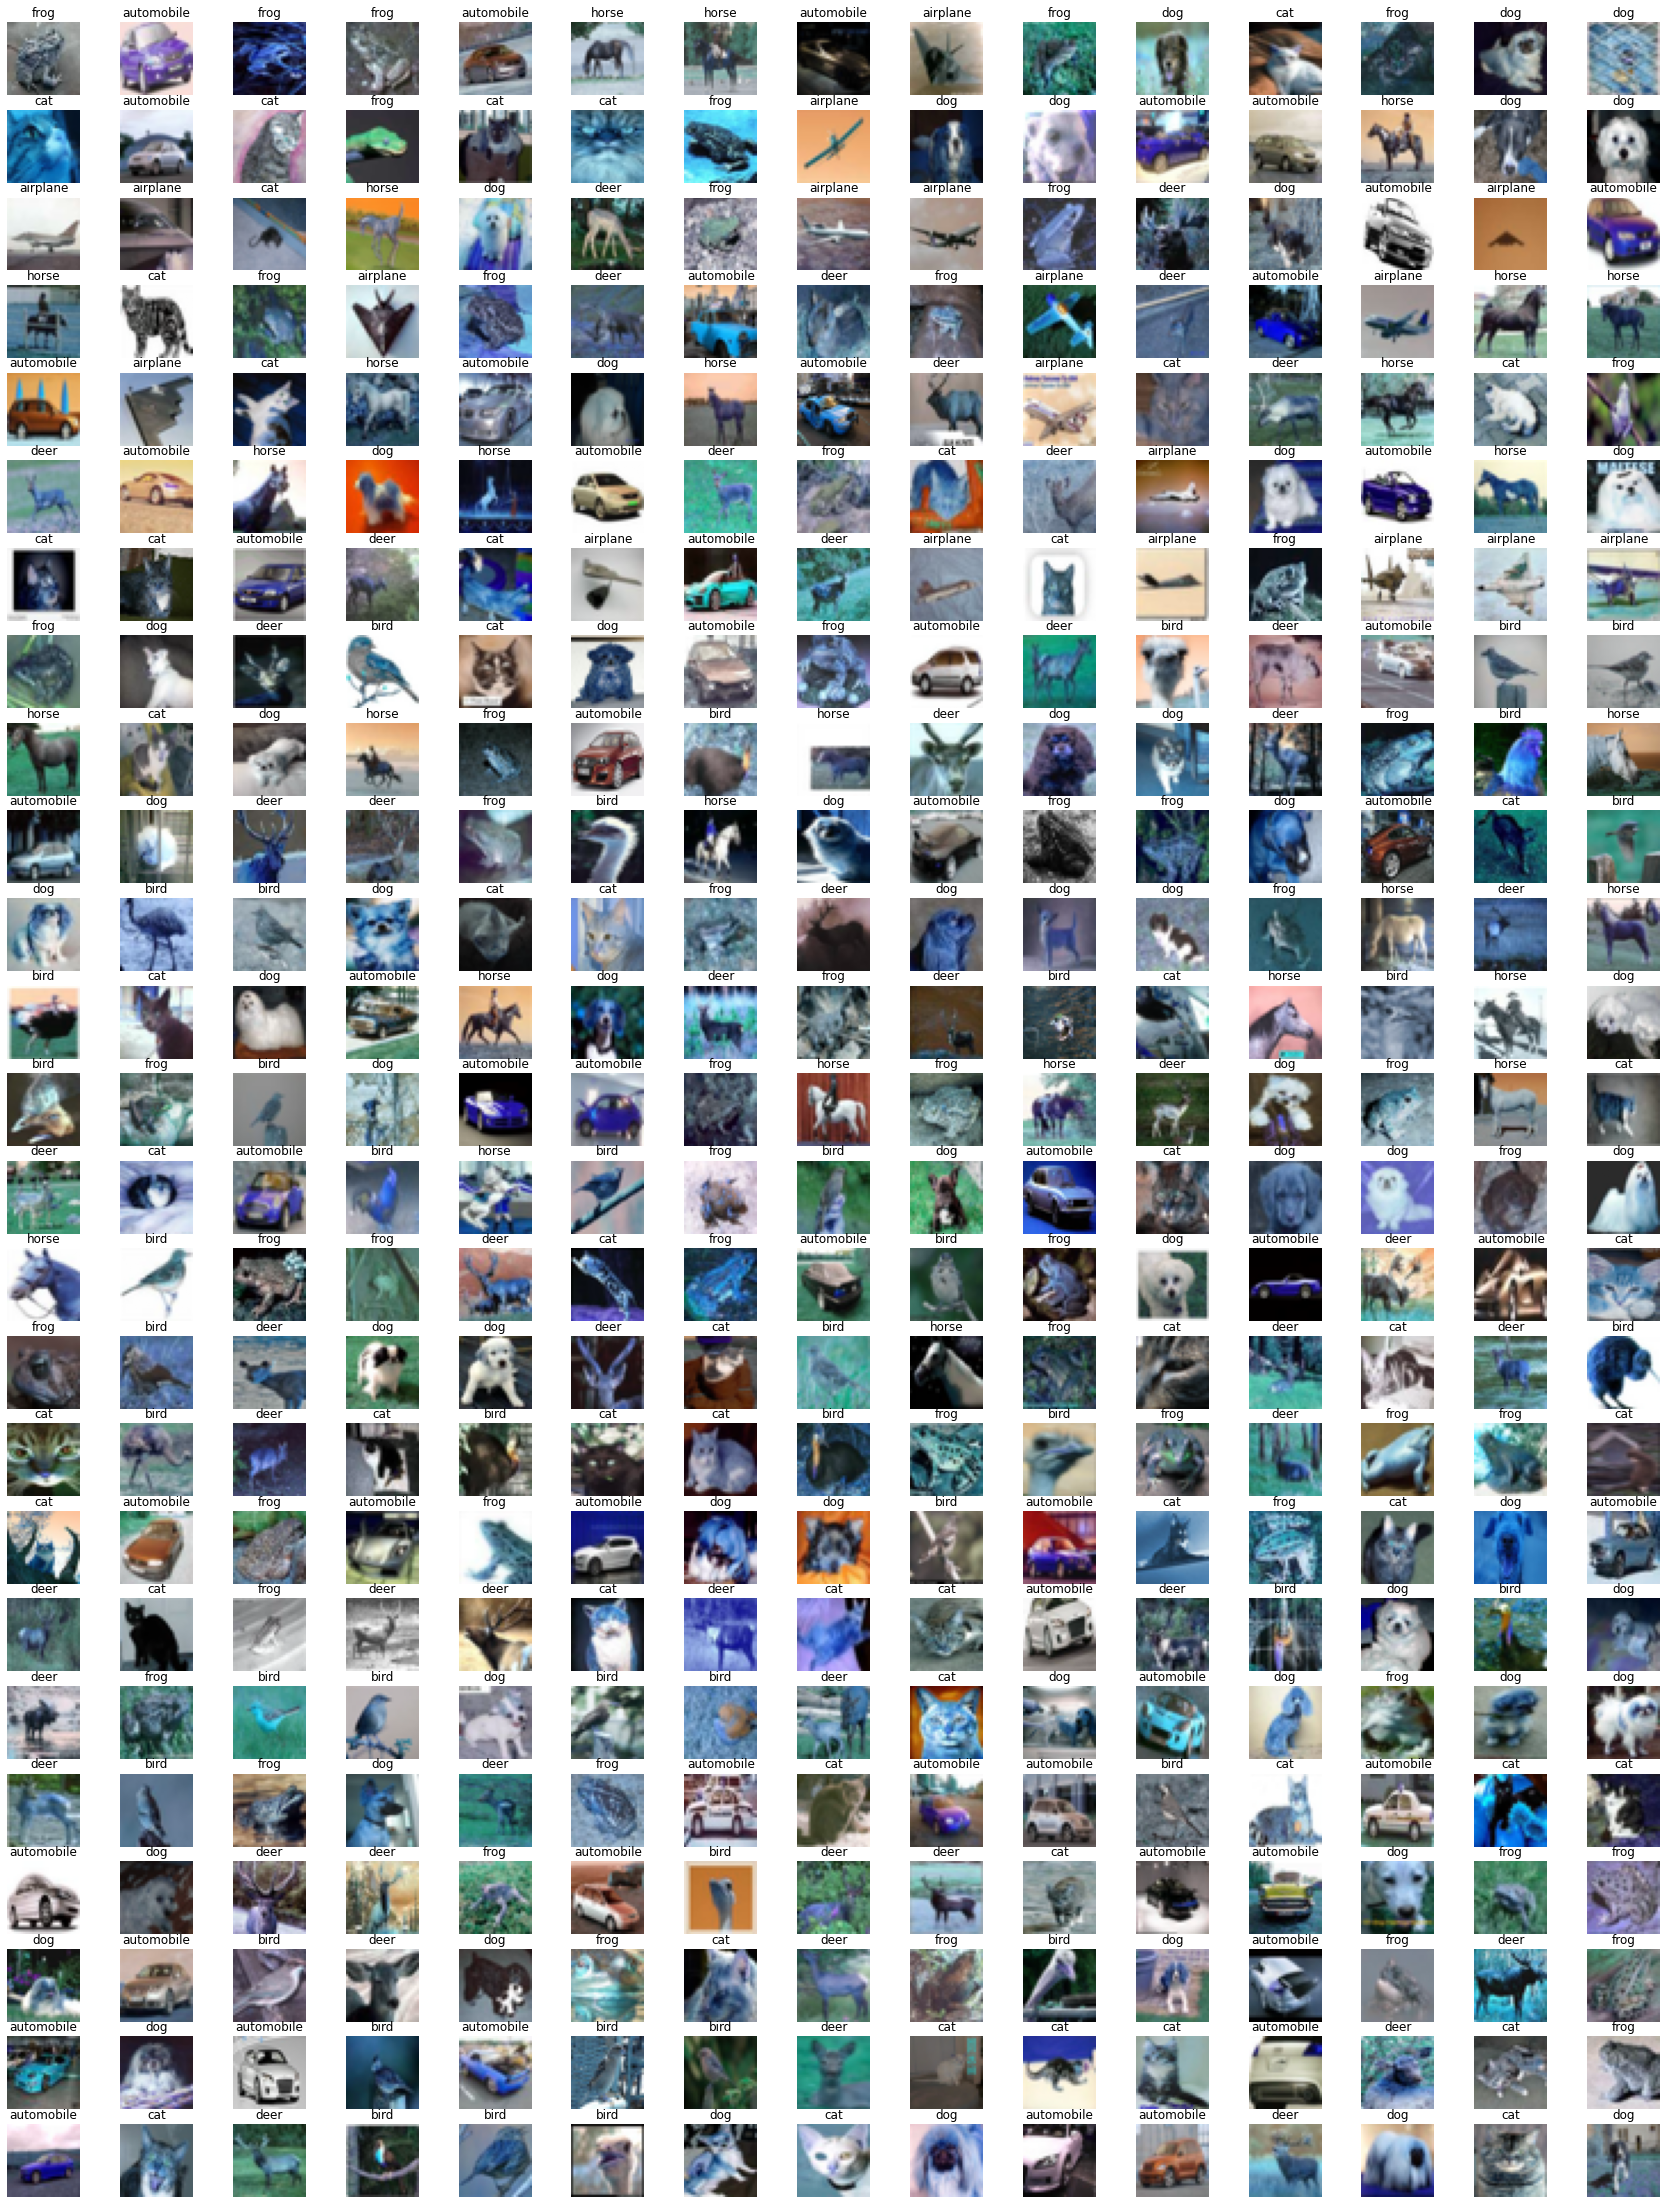

In [7]:
matplotlib.rcParams['figure.figsize'] = (30.0, 40.0)
for i in range(375):
    plt.subplot(25,15,i+1)
    plt.title(labels_to_classes[Y_valid[i]])
    plt.imshow(X_valid[i])
    plt.axis('off')
plt.show()

## 2. Create Resnet Model

**Functions to create keras model**

In [ ]:
def elu_bn(inputs):
    """
    A function for computing elu then batch normalization
    """
    elu = ELU()(inputs)
    bn = BatchNormalization()(elu)
    return bn

def residual_block(x, filters, kernel_size):
    """
    A function to create residual block
    """
    x2 = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    x2 = elu_bn(x2)
    y = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x2)
    y = elu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    out = Add()([x2, y])
    out = elu_bn(out)
    return out

def create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
               filters, kernels, learning_rate):
    """
    A function to create net
    """
    X = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    n_layers = len(kernels)
    for i in range(n_layers):
        if i ==0:
            layer = residual_block(X, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)            
        elif i == n_layers-1:
            layer = residual_block(layer, filters[i], kernels[i])
        else:
            layer = residual_block(layer, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
            
    Y = GlobalAveragePooling2D()(layer)
    Y = Dense(128, activation='elu')(Y)
    Y = BatchNormalization()(Y)
    Y = Dense(N_CLASSES, activation='softmax')(Y)
    
    model = Model(inputs=X, outputs=Y)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

**Create a resnet model**

In [ ]:
clear_session()
num_filters = 64
kernels = [3,3,3,3]
filters = [30,90,180,360]
learning_rate = (1e-3)*0.5
model = create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                   filters, kernels, learning_rate)
model.summary()

## 3. Train Model

In [ ]:
def train_model(model, epochs, batch_size, checkpoint_cb, 
                X_train, Y_train, X_valid, Y_valid):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size,
                        validation_data = (X_valid, Y_valid), 
                        callbacks=[checkpoint_cb])
    return model, history 

In [ ]:
epochs = 100
batch_size = 1024
checkpoint_cb = ModelCheckpoint(MODEL_DIR+"model.h5", monitor = 'val_accuracy', 
                                save_freq = "epoch", save_best_only=True, 
                                mode = "max")
model, history = train_model(model, epochs, batch_size, checkpoint_cb, 
                             X_train, Y_train, X_valid, Y_valid)

## 4. Access performance of model

**Load test data**

In [ ]:
X_train, Y_train = None, None
X_test = np.load(SAVE_DIRECTORY+"X_test.npy")
Y_test = np.load(SAVE_DIRECTORY+"Y_test.npy")

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

**Visualize loss vs epoch graph**

In [ ]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss', linewidth = 10.0)
plt.plot(epochs, val_loss,  label='Validation Loss', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

**Visualize accuracy vs epoch graph**

In [ ]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,  label='Training Accuracy', linewidth = 10.0)
plt.plot(epochs, val_acc,  label='Validation Accuracy', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

**Calculate valid and test accuracy**

In [ ]:
model = load_model(MODEL_DIR+"model.h5")
valid_accuracy = accuracy_score(Y_valid, np.argmax(model.predict(X_valid), axis = -1))
test_accuracy = accuracy_score(Y_test, np.argmax(model.predict(X_test), axis = -1))
print("Valid accuracy:",valid_accuracy)
print("Test accuracy:",test_accuracy)